# 📈 Prédire la valeur de l’action Google dans le futur

**Contexte :** <blockquote> Vous êtes datascientist chez Google en charge d'un nouveau projet autour de TimeSeries. Votre premier projet consiste à proposer une solution permettant de prédire la tendance de l'action Google dans le futur et de former une nouvelle équipe de datascientists (juniors) sur les RNN et en particulier les LSTM.

    
Pour réaliser ce projet, vous avez accés à deux datasets :
* Dataset Train : 5 années d’historique de l’action google 2012 - 2016
* Dataset Test : un mois de données Janvier 2017

Développer une solution basée sur les réseaux de neurones récurrents de type LSTM et permettant de prédire l'action Google dans le futur</blockquote> 

# 👩🏻‍💻 Exploration des données

## Imports

🔎 Import Librairies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

🔎 Import Dataset

In [2]:
df = pd.read_csv('C:/Users/zaome/Documents/Week_formation/Projet_TimeSerie/Google_Stock_Price_Train.csv', index_col='Date', parse_dates=['Date'])
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
#df = pd.read_csv?
#df

## Informations des données

In [4]:
df.shape

(1258, 5)

🔎 Data Information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   object 
 4   Volume  1258 non-null   object 
dtypes: float64(3), object(2)
memory usage: 59.0+ KB


🔎 Data Descriptive

In [6]:
df.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


🔎 Types de données

In [7]:
df.dtypes.value_counts()

float64    3
object     2
dtype: int64

In [8]:
df.dtypes

Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object

🔎 Valeurs manquantes

In [9]:
df.isnull().sum().sort_values()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

🔎 Duplicates

In [10]:
df.duplicated().sum()

0

# 🎨 Visualisations

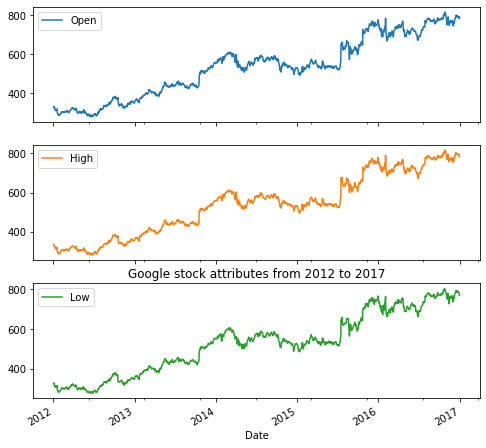

In [11]:
df.plot(subplots=True, figsize=(8,8))
plt.title('Google stock attributes from 2012 to 2017')
plt.show()

**On observe une certaine tendance qui augmente au cours du temps. Nous allons travailler sur la recherche de sa trend de 'Open'.**

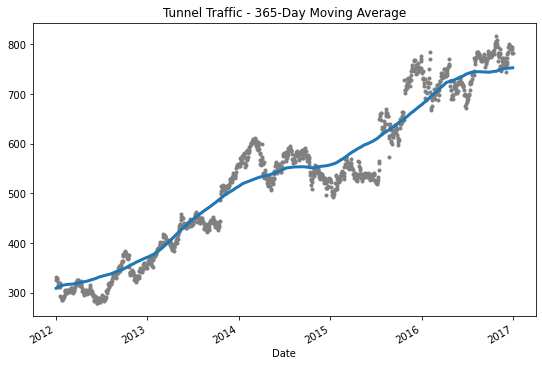

In [39]:
plt.figure(figsize=(9,6))

moving_average = df['Open'].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df['Open'].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

**On observe deux allures différentes :**
-  Soi une croissance assez élevée
-  Soi une période où les actions stagnent/croissance basse

**Il semblerait que l'on soit actuellement dans une période avec une croissance basse.**

# 🌌Preprocessing

## Import librairies

In [12]:
#Preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#Modèle
from keras.models import Sequential
from tensorflow.keras.layers import  LSTM, Dense, Dropout
from tensorflow.keras.metrics import Accuracy

## Normalisation

**Nous nous concentrons uniquement sur le prix d’ouverture de l’action 'Open', et nous prendrons pas en concidération les colonnes qui n’ont pas d’impact sur notre valeur prédite.** 

In [13]:
training_set = df.iloc[:,1:2].values

**Afin d’obtenir toutes ces valeurs entre la plage de 0 à 1, nous utiliserons le MinMaxScaler. La valeur minimale serait 0 et la valeur maximale serait 1. La mise à l’échelle raccourcit le temps d’exécution, tout en réduisant l’erreur.**

In [14]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

## Echantillonnage

**Nous allons entraîner ce modèle dans des données de 60 jours à la fois donc nous allons diviser les données en morceaux de 60 lignes.**

**Dans la boucle for les données commencent à 60 jours et le code s'exécute jusqu’à 1258. Il commencera à partir de [i-60] et ira jusqu’à ce que i soit réellement égal à 60. Les paramètres seront [i,0] dans ce cas, ce qui indique le cours de l’action au 60ème jour.**

In [15]:
df.shape[0]

1258

In [16]:
X_train=[]
y_train=[]
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [17]:
training_set_scaled.shape

(1258, 1)

**Faire un reshape pour stocké les données x_train et y_train dans 2 tableaux numériques différents.**

In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [19]:
X_train.shape

(1198, 60, 1)

In [20]:
y_train.shape

(1198,)

# 🔢 Modèles LSTM

## Couches

4 techniques pour éviter l'overfiting :
* Early stopping
* Regularisation
* Data augmentation (CNN)
* Simplifier l'architecture du réseau

In [21]:
regressor = Sequential()

* La **return_sequences** est définie sur True, afin de renvoyer la séquence complète dans la sortie. 
* Pour une seule couche, les dimensions seraient de 60 par 5. Chaque ligne a une forme de 60 par 5 pour la longueur du jeu de données d’apprentissage.
* Rajouter le **Dropout** si ça Overfit : il désactive aléatoirement un pourcentage de couche

In [22]:
regressor.add(LSTM(units=60,return_sequences=True,input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.3))

In [23]:
regressor.add(LSTM(units=60,return_sequences=True))
regressor.add(Dropout(0.3))

In [24]:
regressor.add(LSTM(units=80,return_sequences=True))
regressor.add(Dropout(0.3))

In [25]:
regressor.add(LSTM(units=100))
regressor.add(Dropout(0.3))

**En ajoutant la couche Dense, nous affirmons simplement que les neurones de cette couche sont entièrement connectés aux neurones de la couche précédente.**

In [26]:
regressor.add(Dense(units = 1))

## Modèle

**On compile le modèle en utlisant l'optimisation 'adam' pour l formation du modèle. Et la fonction de perte sera l’erreur quadratique moyenne, 'mean_squared_error', comparant les valeurs observées aux valeurs prédites.**

In [27]:
regressor.compile(optimizer='adam', loss='mean_squared_error')

**Nous utiliserons 40 époques pour former ce modèle. Et un batch_size de 32, qui indique le nombre d’échantillons d’entraînement utilisés pour chaque itération via le réseau neuronal.**

In [28]:
validation_split = 0.2
history = regressor.fit(X_train, y_train, validation_split = validation_split, epochs = 50, batch_size = 32)

Epoch 1/50
30/30 [==============================] - 74s 1s/step - loss: 0.0231 - val_loss: 0.0114
Epoch 2/50
30/30 [==============================] - 34s 1s/step - loss: 0.0049 - val_loss: 0.0034
Epoch 3/50
30/30 [==============================] - 30s 992ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 4/50
30/30 [==============================] - 29s 987ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 5/50
30/30 [==============================] - 29s 976ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 6/50
30/30 [==============================] - 20s 666ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 7/50
30/30 [==============================] - 25s 838ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 8/50
30/30 [==============================] - 24s 803ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 9/50
30/30 [==============================] - 23s 762ms/step - loss: 0.0042 - val_loss: 0.0151
Epoch 10/50
30/30 [==============================] - 22s 723ms/step - loss: 0.0045 - val_loss: 0.

Score

In [29]:
regressor.evaluate(X_train, y_train)

38/38 [==============================] - 4s 107ms/step - loss: 0.0011


0.001111153862439096

Paramètres

In [30]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 60)            14880     
                                                                 
 dropout (Dropout)           (None, 60, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            29040     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               7

Learning Curve

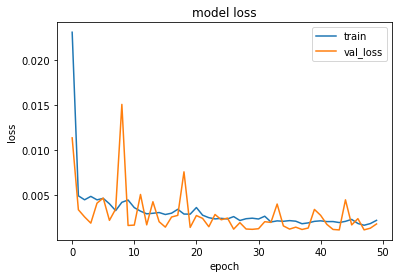

In [31]:
# Courbe loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])

plt.show()

# 💀 Modèle test

Pour prédir le 3 janvier concatener le jeu de train avec le jeu de test pour avoir autant de données dans le test

Refaire les mêmes étapes que pour le train :
* Normaliser
* Transformer en séquence
* Reshape
* Predict : Données normalisées --> Inverse transforme les données

In [32]:
test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = test.iloc[:, 1:2].values
total_data=pd.concat([df['Open'],test['Open']],axis=0)

In [33]:
inputs = total_data[len(df)-len(test)-60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [34]:
X_test=[]
for i in range(60,80):
    X_test.append(inputs[i-60:i,0])
X_test=np.array(X_test)
X_test.shape
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [35]:
predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

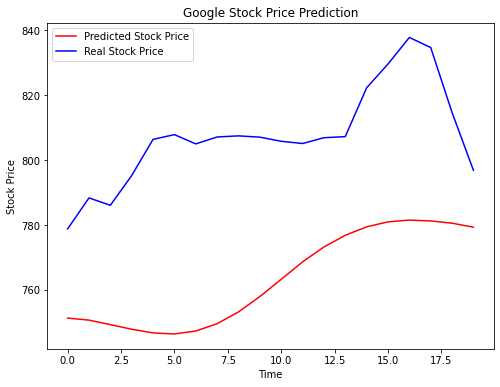

In [36]:
#Visualization
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(predicted,color='red',label='Predicted Stock Price')
plt.plot(real_stock_price,color='blue',label='Real Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# 👨🏻‍💼 Modèle simple RNN

In [38]:
from keras.layers import SimpleRNN

#Initialize RNN:
regressor_rnn = Sequential()

#Adding the first RNN layer and some Dropout regularization
regressor_rnn.add(SimpleRNN(units = 60, activation='tanh', return_sequences=True, input_shape= (X_train.shape[1],1)))
regressor_rnn.add(Dropout(0.2))

#Adding the second RNN layer and some Dropout regularization
regressor_rnn.add(SimpleRNN(units = 60, activation='tanh', return_sequences=True))
regressor_rnn.add(Dropout(0.2))

#Adding the third RNN layer and some Dropout regularization
regressor_rnn.add(SimpleRNN(units = 60, activation='tanh', return_sequences=True))
regressor_rnn.add(Dropout(0.2))

#Adding the fourth RNN layer and some Dropout regularization
regressor_rnn.add(SimpleRNN(units = 60))
regressor_rnn.add(Dropout(0.2))

#Adding the output layer
regressor_rnn.add(Dense(units = 1))

#Compile the RNN
regressor_rnn.compile(optimizer='adam', loss='mean_squared_error')

#Fitting the RNN to the Training set
validation_split = 0.2
history_rnn = regressor_rnn.fit(X_train, y_train, validation_split=validation_split, epochs=50, batch_size=32)

Epoch 1/50
30/30 [==============================] - 9s 159ms/step - loss: 0.4152 - val_loss: 0.0839
Epoch 2/50
30/30 [==============================] - 3s 102ms/step - loss: 0.2469 - val_loss: 0.0017
Epoch 3/50
30/30 [==============================] - 4s 122ms/step - loss: 0.2053 - val_loss: 0.0381
Epoch 4/50
30/30 [==============================] - 4s 133ms/step - loss: 0.1423 - val_loss: 0.0033
Epoch 5/50
30/30 [==============================] - 11s 359ms/step - loss: 0.1183 - val_loss: 0.0059
Epoch 6/50
30/30 [==============================] - 6s 202ms/step - loss: 0.0997 - val_loss: 0.0092
Epoch 7/50
30/30 [==============================] - 6s 216ms/step - loss: 0.0841 - val_loss: 0.0424
Epoch 8/50
30/30 [==============================] - 7s 232ms/step - loss: 0.0683 - val_loss: 0.0033
Epoch 9/50
30/30 [==============================] - 6s 209ms/step - loss: 0.0608 - val_loss: 0.0024
Epoch 10/50
30/30 [==============================] - 6s 186ms/step - loss: 0.0492 - val_loss: 0.001

In [40]:
regressor_rnn.evaluate(X_train, y_train)

38/38 [==============================] - 1s 19ms/step - loss: 9.1073e-04


0.0009107340010814369

In [41]:
regressor_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 60, 60)            3720      
                                                                 
 dropout_4 (Dropout)         (None, 60, 60)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 60, 60)            7260      
                                                                 
 dropout_5 (Dropout)         (None, 60, 60)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 60, 60)            7260      
                                                                 
 dropout_6 (Dropout)         (None, 60, 60)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 60)               

In [43]:
# Courbe loss
plt.plot(history_rnn.history_rnn['loss'])
plt.plot(history_rnn.history_rnn['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])

plt.show()

AttributeError: 'History' object has no attribute 'history_rnn'